<a href="https://colab.research.google.com/github/AyobamiAdebesin/Deep-RotNet/blob/main/ImageRotationDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the required libraries
import numpy as np
import matplotlib.pyplot as plt
import keras 
import tensorflow as tf
import scipy
import os, shutil
import time
import cv2

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# helper functions
def rotate_image(img_path):
    image = cv2.imread(img_path)
    height, width = image.shape[:2]
    # Divide by two to rotate the image around its centre
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), 180, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    save_rot = cv2.imwrite(img_path, rotated_image)
    return rotated_image

In [ ]:
# Create directories to store images
original_dataset_dir = 'content/datasets'
base_dir = 'content/dataset/'

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)

    validation_dir = os.path.join(base_dir, 'validation')
    os.mkdir(validation_dir)

    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

    train_unrotated_dir = os.path.join(train_dir, 'unrotated')
    os.mkdir(train_unrotated_dir)
    train_rotated_dir = os.path.join(train_dir, 'rotated')
    os.mkdir(train_rotated_dir)

    val_unrotated_dir = os.path.join(validation_dir, 'unrotated')
    os.mkdir(val_unrotated_dir)
    val_rotated_dir = os.path.join(validation_dir, 'rotated')
    os.mkdir(val_rotated_dir)

    test_unrotated_dir = os.path.join(test_dir, 'unrotated')
    os.mkdir(test_unrotated_dir)
    test_rotated_dir = os.path.join(test_dir, 'rotated')
    os.mkdir(test_rotated_dir)

else:
    pass



'/content'

In [25]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
tf.config.run_functions_eagerly(False)
print("Eager execution: {}".format(tf.executing_eagerly()))
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
import scipy.misc

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard


TensorFlow version: 2.8.0
Eager execution: True


In [10]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
#     value = tensor[0][0][0]
#     wtm = tf.fill((10,10,1), value)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding ='same', kernel_initializer= initializer(seed = 0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, padding='valid', strides = (1,1),  kernel_initializer= initializer(seed = 0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X


def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides=(1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides=(1,1), padding = "valid", kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides=(s,s), padding='valid', kernel_initializer= initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training = training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def ResNet50(input_shape = (224, 224, 3), classes = 2):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, s=2, filters= [128, 128, 512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, s=2, filters= [256, 256, 1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024]) 

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, s=2, filters= [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048]) 

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2))(X) 
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [11]:
model = ResNet50(input_shape = (224, 224, 3), classes = 1)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_106 (Conv2D)            (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [13]:
# Compile dataset
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [20]:
#Datasets directory
train_dir = '/content/drive/MyDrive/dataset/train'
validation_dir = '/content/drive/MyDrive/dataset/validation'
test_dir = '/content/drive/MyDrive/dataset/test'

In [28]:
# Preprocesing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_datagen = train_gen.flow_from_directory(train_dir, class_mode='binary', batch_size=20,target_size=(224, 224))
val_datagen = test_gen.flow_from_directory(validation_dir, class_mode='binary', batch_size=20, target_size=(224, 224))



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [30]:
model_name = 'RotNet'
output_folder = 'models'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# callbacks
monitor = 'val_angle_error'
checkpointer = ModelCheckpoint(
    filepath=os.path.join(output_folder, model_name + '.hdf5'),
    monitor=monitor,
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(monitor=monitor, patience=3)
early_stopping = EarlyStopping(monitor=monitor, patience=5)
tensorboard = TensorBoard()

# Train the model
history = model.fit_generator(train_datagen, steps_per_epoch=100, epochs = 50, validation_data=val_datagen, validation_steps=50,
    callbacks=[checkpointer, reduce_lr, early_stopping, tensorboard],
    workers=10)

model.save(model_name+'.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
100/100 [==============================] - 90s 859ms/step - loss: 0.6423 - acc: 0.7865 - val_loss: 0.6234 - val_acc: 0.8400 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - 79s 779ms/step - loss: 0.4190 - acc: 0.8920 - val_loss: 0.2498 - val_acc: 0.9280 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - 78s 778ms/step - loss: 0.2309 - acc: 0.9315 - val_loss: 0.1970 - val_acc: 0.9430 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - 78s 778ms/step - loss: 0.2116 - acc: 0.9295 - val_loss: 0.2308 - val_acc: 0.9440 - lr: 1.0000e-04
Epoch 5/50
100/100 [==============================] - 68s 674ms/step - loss: 0.1846 - acc: 0.9425 - val_loss: 0.2579 - val_acc: 0.9340 - lr: 1.0000e-04
Epoch 6/50
100/100 [==============================] - 78s 777ms/step - loss: 0.1611 - acc: 0.9445 - val_loss: 0.2518 - val_acc: 0.9540 - lr: 1.0000e-04
Epoch 7/50
100/100 [==============================] - 68s 675ms/step - loss: 0.1449 - ac

In [61]:
#Evaluate model on test set
test_datagen = test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=20, class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_datagen, steps=50)
print('test accuracy: ', test_acc )

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


test accuracy:  0.9319999814033508


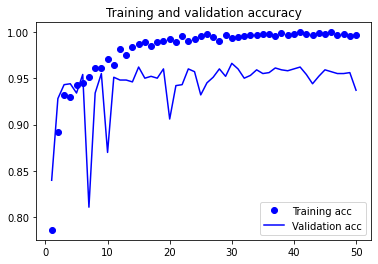

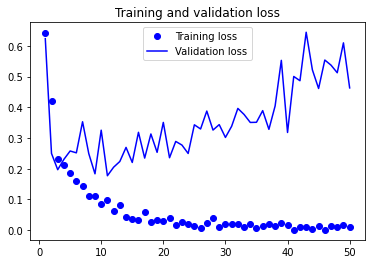

In [69]:
# Plot training stats
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [45]:
# Test the model
test_rot = '/content/drive/MyDrive/dataset/test/rotated/'
test_unrot = '/content/drive/MyDrive/dataset/test/unrotated/'

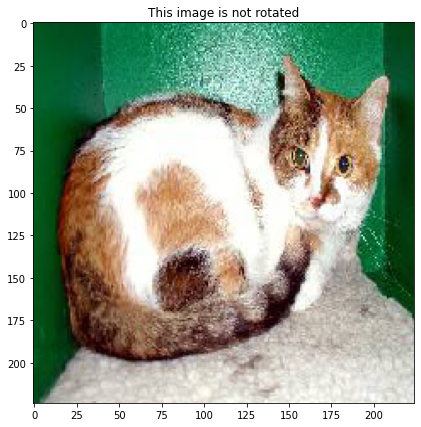

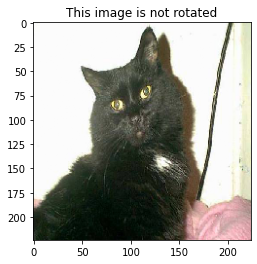

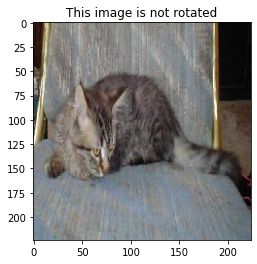

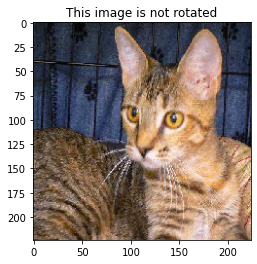

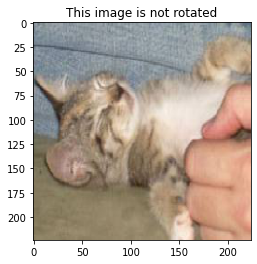

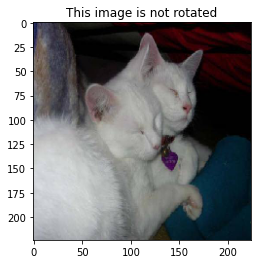

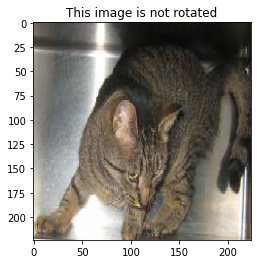

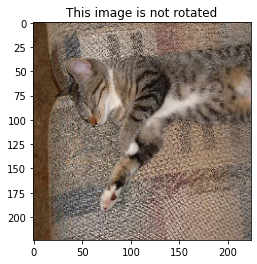

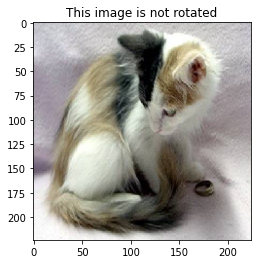

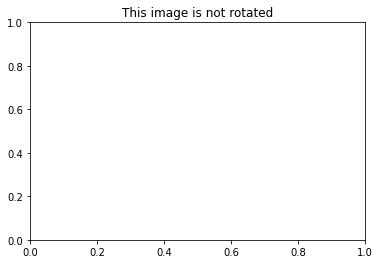

In [82]:
# Predict the result
from tensorflow.keras.preprocessing import image
result = np.zeros((10))

fig = plt.figure(figsize=(10, 7))
# result = model.predict(test_image)
for i in range(10):
  test_image = image.load_img(test_unrot+os.listdir(test_unrot)[i], target_size = ((224, 224)))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  test_image /= 255
  val = model.predict(test_image)
  plt.imshow(test_image[0])
  plt.figure(i+1)
  if val > 0.5:
    plt.title('This image is not rotated')
    result[i] = 1
  elif val < 0.5:
    plt.title("This image is rotated")
    result[i] = 0
plt.show()

  

In [83]:
result

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])